### Optimal pooling example

Some characteristics of optimal pooling:
- **Different bins**: Bins should be distinct from each other and not overlap. This ensures that the continuous variable is properly discretized and can help avoid confusion when interpreting the results.
- **Balanced distribution**: The number of observations in each bin should be roughly equal or at least not highly skewed. This helps ensure that each bin contributes meaningfully to the model and prevents any single bin from dominating the results.
- **Minimal Gini decrease**: The Gini index is a measure of statistical dispersion, often used to assess the quality of a split in decision trees. In optimal binning, a smaller decrease in the Gini index indicates that the bins are more homogeneous, leading to better model performance.
- **Monotonic relationship**: Ideally, bins should have a monotonic relationship with the target variable, meaning that the relationship should consistently increase or decrease as the bin values change. This simplifies interpretation and can improve model performance.
- **Interpretability**: The bins should be easy to understand and interpret, with meaningful boundaries that are relevant to the domain of the problem. This helps stakeholders better understand the results and can aid in decision-making.
- **Stability**: Good optimal binning should be stable and not sensitive to small changes in the data. This ensures that the model's performance is robust and reliable.
- **Domain knowledge**: The binning process should take into account domain knowledge and expert input when determining the bin boundaries. This can help ensure that the bins are meaningful and relevant to the problem at hand.

-----------------------------

#### Objective Function

Maximize IV value of the bins

IV = ∑((Good% - Bad%) * ln(Good% / Bad%)), where Good% and Bad% are the proportions of non-default and default observations, respectively, in each bin.

**Constraints**:
- The default rate per bin should be monotonically increasing or decreasing.
- The bins should be statistically different (determined by the Chi-square test or another suitable hypothesis test with a chosen significance level).
- The minimum number of observations per bin should be met.
- The minimum and maximum number of bins should be within the specified range.

**Variables**:
- Bins as a set of ordinal categories.
- Default rate: The proportion of default observations (default_flag = 1) in each bin.
- A similar problem is solved here: https://github.com/guillermo-navas-palencia/optbinning/blob/master/optbinning/binning/cp.py

In [1]:
from ortools.sat.python import cp_model
from scipy import special
from sklearn.tree import DecisionTreeRegressor, _tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import time
import functools, os
from functools import wraps
import psutil
import tracemalloc

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

### A. Create a synthetic dataset

In [2]:
# Set a seed so the randomness is reproducible
np.random.seed(0)

# Number of samples
n_samples = 1_000_000

# Generate columns
target = np.random.binomial(1, 0.05, n_samples)
year = np.random.randint(2010, 2023, n_samples)

x1 = np.random.rand(n_samples)
x1_noise = np.random.normal(0, 0.5, n_samples)
x1 = 0.5 * x1 + 0.5 * target + x1_noise

x2 = np.sin(3*np.pi*np.random.rand(n_samples))
x2_noise = np.random.normal(0, 0.5, n_samples)
x2 = 0.5 * x2 + 0.5 * target + x2_noise

x3_noise = np.random.normal(0, 0.5, n_samples)
x3 = 0.5 * x1 + 0.1 * target + x1_noise

# Consolidate all the columns into a DataFrame
df = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'year': year,
    'target': target,
})

# Define the logistic regression model
model = LogisticRegression()

# Fit the model
X = df[['x1', 'x2']]
y = df['target']
model.fit(X, y)

# Make predictions (probabilities)
y_pred_proba = model.predict_proba(X)[:, 1]
df['score'] = y_pred_proba

# Compute Gini coefficient
gini = 2*roc_auc_score(y, y_pred_proba) - 1
print(f"Gini: {gini:.2%}")

Gini: 63.07%


### B. Create possible cut-off thresholds and annual default rates

This step can be replaced by equal-width / equal-height / xgboost binning

In [3]:
# Set the number of bins you want
n_bins = 40

# Set the max_depth, min_samples_leaf, and max_leaf_nodes parameters
clf = DecisionTreeRegressor(max_depth=n_bins, 
                            min_samples_leaf=1000, 
                            max_leaf_nodes=n_bins)

clf.fit(df[['score']], df['target'])
thresholds = clf.tree_.threshold[clf.tree_.threshold > _tree.TREE_UNDEFINED]

# Add minimum and maximum edges
bins = sorted([-np.inf] + list(thresholds) + [np.inf])
df['bins'] = pd.cut(df['score'], bins, labels=False)

print([round(num, 4) for num in bins])

[-inf, 0.0069, 0.0109, 0.0173, 0.0252, 0.0326, 0.0378, 0.0499, 0.059, 0.0683, 0.0838, 0.1043, 0.1136, 0.1278, 0.1307, 0.1449, 0.1462, 0.1598, 0.1615, 0.167, 0.1697, 0.1721, 0.1839, 0.2078, 0.211, 0.2347, 0.2415, 0.2472, 0.2514, 0.2901, 0.3023, 0.3331, 0.3574, 0.3847, 0.4012, 0.4198, 0.4394, 0.4681, 0.5074, 0.6187, inf]


In [4]:
drs = df.pivot_table(index='year', columns='bins', values='target', aggfunc='mean', margins='all').T
drs.style.format("{:.2%}")

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,All
bins,,,,,,,,,,,,,,
0,0.36%,0.35%,0.45%,0.42%,0.46%,0.50%,0.43%,0.42%,0.47%,0.40%,0.36%,0.44%,0.44%,0.42%
1,0.82%,0.98%,1.03%,0.88%,1.03%,0.80%,0.86%,1.07%,0.99%,0.88%,0.73%,0.85%,1.17%,0.93%
2,1.36%,1.75%,1.54%,1.44%,1.36%,1.65%,1.28%,1.47%,1.28%,1.70%,1.42%,1.40%,1.31%,1.46%
3,2.00%,2.10%,2.01%,2.39%,1.98%,2.04%,2.30%,2.22%,2.21%,2.43%,1.94%,2.10%,2.17%,2.15%
4,2.79%,3.12%,2.90%,3.23%,2.55%,2.91%,2.82%,2.60%,2.99%,2.69%,2.83%,2.99%,2.86%,2.87%
5,3.92%,3.50%,2.73%,3.75%,3.82%,4.00%,3.34%,3.67%,3.36%,3.85%,3.07%,3.45%,3.27%,3.52%
6,5.12%,4.37%,4.17%,4.38%,4.09%,4.22%,4.05%,3.82%,3.91%,4.54%,4.66%,4.20%,4.38%,4.30%
7,5.01%,5.34%,5.58%,4.63%,5.72%,4.88%,5.78%,5.08%,5.51%,5.01%,5.10%,5.24%,5.45%,5.26%
8,5.75%,5.94%,5.99%,5.70%,6.45%,6.77%,6.38%,6.54%,6.28%,5.70%,6.13%,6.26%,5.75%,6.13%


### C. Create optimisation function
Some functions are inspired by optbinning.

In [5]:
def memory_time_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        start_time = time.time()

        results = func(*args, **kwargs)

        end_time = time.time()
        
        current, malloc_peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        execution_time = end_time - start_time

        print(f"Function {func.__name__} peaked at {malloc_peak / 1024**2:.2f} MB.")
        print(f"Function {func.__name__} executed in {execution_time:.2f} seconds.")

        return results
    return wrapper

def calculate_iv(events, non_events, total_events, total_non_events):
    # Calculate the percentage of events and non-events
    event_rate = events / total_events
    non_event_rate = non_events / total_non_events

    # Add a constant to the denominator to avoid division by zero
    event_rate = np.where(event_rate == 0, 0.000001, event_rate)
    
    WoE = np.log(non_event_rate / event_rate)
    IV = (non_event_rate - event_rate) * WoE

    return IV

def test_proportions(event_1, non_event_1, event_2, non_event_2):
    total_1 = event_1 + non_event_1
    total_2 = event_2 + non_event_2
    proportion_1 = event_1 / total_1
    proportion_2 = event_2 / total_2
    pooled_proportion = (event_1 + event_2) / (total_1 + total_2)

    z = ((proportion_1 - proportion_2) / np.sqrt(pooled_proportion * 
         (1 - pooled_proportion) * (1 / total_1 + 1 / total_2)))
    return abs(z)              
                
def individual_bin_stats(events, non_events):
    ''' Create stats for all purposes'''
    n = len(events)
    stats = {}
    
    counts = events + non_events
    total_events = events.sum()
    total_non_events = (counts - events).sum()
    

    for i in range(n+1):
        for j in range(i, n):
            # Calculate the combined events and non-events for each bin combination
            combined_events = events[i:j+1].sum()
            combined_non_events = (counts[i:j+1] - events[i:j+1]).sum()

            # Calculate IV for this bin combination
            iv = calculate_iv(combined_events, combined_non_events, total_events, total_non_events)
            default_rate = combined_events / (combined_events + combined_non_events)
                
            stats[(i+1, j+1)] = [iv, 
                                 combined_events, 
                                 combined_non_events, 
                                 total_events, 
                                 total_non_events, 
                                 default_rate]

    return stats

def bin_combo_stats(stats_b):
    result_stats = {}
    for a in stats_b:
        for b in stats_b:
            if a[1] == b[0]-1:
                e1 = stats_b[a][1]
                ne1 = stats_b[a][2]
                e2 = stats_b[b][1]
                ne2 = stats_b[b][2]
                
                # Calculate mononicity of consecutive default rates
                default_rate_1 = stats_b[a][5]
                default_rate_2 = stats_b[b][5]
                trend = 1 if default_rate_1 > default_rate_2 else 0
                
                # CaLculate z-score of adjacent bins
                z_score = test_proportions(e1, ne1, e2, ne2)
                
                # Store results
                result_stats[a, b] = [z_score, trend]
                
    return result_stats
                
class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """ Intermediate solutions for debugging and multiple solutions """

    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0

    def on_solution_callback(self):
        self.__solution_count += 1
        for v in self.__variables:
            pass
            
@memory_time_decorator
def create_pools(events, non_events, lra_drs, min_bins, max_bins):
    ''' Finds optimal binning given potential cutoffs '''
    
    n = len(events)
    
    # Create the model.
    model = cp_model.CpModel()

    # Variables
    x = {}
    iv = {}
    bins = []
    for i in range(1, n+1):
        for j in range(i, n+1):
            # x[i, j] is a boolean that is true if included in the combination
            x[i, j] = model.NewBoolVar(f'x[{i},{j}]')
    
    # Create supporting data
    bin_data = individual_bin_stats(events, non_events)        
    iv = {key: val[0] for key, val in bin_data.items()}
    
    # Create bin options that should be excluded from consideration
    excluded_bin_combos = bin_combo_stats(bin_data)
    
    # Testing: todo delete
    # iv[2, 4] = 12007
    # excluded_bin_combos[(2, 4), (5, 6)] = [0.1, 1]
    # excluded_bin_combos[(2, 4), (5, 5)] = [0.1, 0]
    
    # Constraints
    for i in range(1, n+1):
        # Each bin i should be included in exactly one tuple.
        model.Add(sum(x[j, k] for j in range(1, i+1) for k in range(i, n+1)) == 1)
        
    # Reject bins if the z-score is below the desired threshold (todo: check signs)
    for key, value in excluded_bin_combos.items():
        if value[0] < 1.0:
            ((i1, j1), (i2, j2)) = key
            model.Add(x[i1, j1] + x[i2, j2] <= 1)
            
    # Reject bins if the default rates are not monotonically increasing
    for key, value in excluded_bin_combos.items():
        if value[1] == 1:
            ((i1, j1), (i2, j2)) = key
            model.Add(x[i1, j1] + x[i2, j2] <= 1)    

    # Maximum number of bins (max_bins)
    model.Add(sum(x[i, j] for i in range(1, n+1) for j in range(i, n+1)) <= max_bins)

    # Minimum number of bins (min_bins)
    model.Add(sum(x[i, j] for i in range(1, n+1) for j in range(i, n+1)) >= min_bins)


    # Objective function
    model.Maximize(sum(iv[i, j] * x[i, j] for i in range(1, n+1) for j in range(i, n+1)))

    # Create a solver and solve.
    solver = cp_model.CpSolver()
    solution_printer = VarArraySolutionPrinter(x)
    status = solver.SolveWithSolutionCallback(model, solution_printer)

    if status == cp_model.OPTIMAL:
        print(f'Total IV = {solver.ObjectiveValue():.2f}, optimal solution')
        for i in range(1, n+1):
            for j in range(i, n+1):
                if solver.Value(x[i, j]) == 1:
                    bins.append([i-1, j-1])

    return bins, status, solver, iv, bin_data, excluded_bin_combos

### D. Solve the optimisation task

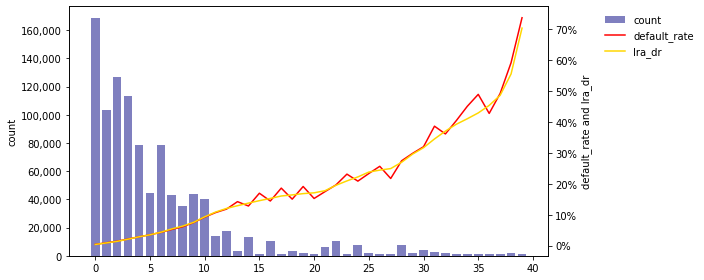

In [6]:
# Get input data per bin
stats_combined = df.groupby('bins').agg({'target': ['sum', 'count']})
stats_combined = stats_combined.reset_index()
stats_combined.columns = ['bins', 'events', 'count']
stats_combined['non_events'] = stats_combined['count'] - stats_combined['events']
stats_combined['default_rate'] = stats_combined['events'] / stats_combined['count']

# Add long-run averages
annual_averages = df.groupby(['bins', 'year'])['score'].mean()
average_scores_per_bin = annual_averages.groupby('bins').mean().reset_index()
average_scores_per_bin.columns = ['bins', 'lra_dr']

stats_combined = pd.merge(stats_combined, average_scores_per_bin, on='bins', how='left')

def plot_stats(df):
    fig, ax1 = plt.subplots(figsize=(10,4)) 

    ax1.set_ylabel('count', color='black')
    lns3 = ax1.bar(df['bins'], df['count'], color='navy', alpha=0.5, label='count')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}')) # Formatting secondary y-axis

    ax2 = ax1.twinx()
    ax2.set_xlabel('bins')
    ax2.set_ylabel('default_rate and lra_dr', color='black')
    lns1 = ax2.plot(df['bins'], df['default_rate'], color='red', label='default_rate')
    lns2 = ax2.plot(df['bins'], df['lra_dr'], color='gold', label='lra_dr')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Formatting primary y-axis

    lns = [lns3] + lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper left', bbox_to_anchor=(1.1, 1.0), frameon=False)

    fig.tight_layout()
    plt.show()
    
plot_stats(stats_combined)

In [7]:
# Test solution
events = stats_combined['events']
non_events = stats_combined['non_events']
lra_drs = stats_combined['lra_dr']

bins, _, _, iv, bin_data, excluded = create_pools(events, non_events, lra_drs, 5, 20)

Total IV = 1.60, optimal solution
Function create_pools peaked at 2.69 MB.
Function create_pools executed in 1.61 seconds.


In [8]:
# Create a mapping table between new and old bins
mapping = []
for i, b in enumerate(bins):
    for j in range(b[0], b[1]+1):
        mapping.append((j, i))

mapping_df = pd.DataFrame(mapping, columns=['bins', 'opt_bins'])

# Assume df is your original DataFrame, merge with mapping_df
df = df.merge(mapping_df, on='bins', how='left')

In [9]:
df.groupby('opt_bins').agg({'target':['count', 'mean']})

target          
           count      mean
opt_bins                  
0         168401  0.004222
1         103584  0.009297
2         127051  0.014585
3         113445  0.021455
4          78407  0.028684
5          44587  0.035190
6          78352  0.043024
7          42966  0.052553
8          35070  0.061277
9          43570  0.074891
10         40090  0.092267
11         31162  0.113343
12         27788  0.137433
13         14222  0.169456
14         23801  0.209613
15         13308  0.291404
16          5783  0.380252
17          4733  0.465033
18          2273  0.591729
19          1407  0.737029